In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

bike_rentals = pd.read_csv('data/hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Exploring the Data

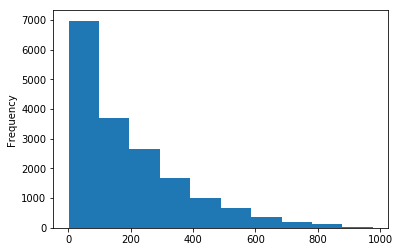

In [2]:
bike_rentals['cnt'].plot.hist()

On most days, the count of rentals doesn't exceed 100-200.

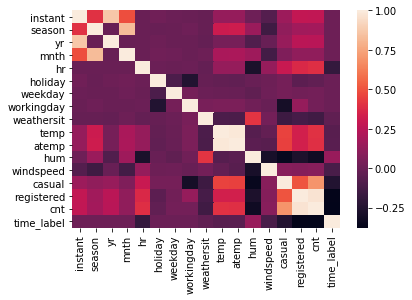

In [28]:
sns.heatmap(bike_rentals.corr())

- Although `casual` and `registered` have a high correlation with count, they derived form our target and should not be included in our model
- `temp` and `atemp` are closely related and we should probably only include one of them when we train our model
- Holidays, high humidity, and adverse weather conditions all negatively impact the amount of rentals

In [4]:
def assign_label(hour):
    if hour >= 0 and hour < 6:
        return 4
    elif hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour < 24:
        return 3

In [5]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

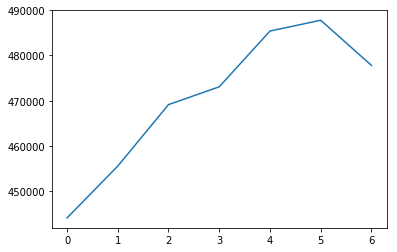

In [6]:
plt.plot(bike_rentals.groupby('weekday')['cnt'].sum())

Days of the week are often categorized in models, due to the fact that there isn't always a linear relationship between our target. In this case however, we do genreally see a positive linear pattern.

In [20]:
bike_rentals.corrwith(bike_rentals['time_label'])

instant       0.006705
season        0.006617
yr            0.004755
mnth          0.005786
hr           -0.187486
holiday      -0.000702
weekday       0.002173
workingday   -0.000897
weathersit   -0.035784
temp         -0.061551
atemp        -0.057494
hum           0.144593
windspeed    -0.109462
casual       -0.250076
registered   -0.371916
cnt          -0.378318
time_label    1.000000
dtype: float64

Often when there is a high correlation between two features, it indicates that two features may be giving us the same information if we use them to train our model. In this case, adding a time label we can see there isn't a strong correlation with any of the time-based features and would make a good addition to our model.

## Error Metric
The error metric we'll use to evaluate our model will be the mean squared error. This datset has a lot of continuous, numerical data, which is a good fit for the MSE.

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = bike_rentals.columns.to_list()
features.remove('cnt')
X_train, X_test, y_train, y_test = train_test_split(bike_rentals[features], bike_rentals['cnt'], train_size=0.8, random_state=5)

/home/tsuzukuri/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Applying Linear Regression
We'll run several models next to see how they compare with one another. The first is Linear Regression.

For feature selections, below are a few notes:
- Casual, Registered are derived from our target feature and would not be good to use in the model
- Index, Dteday are index values
- Temp and atemp are very closely related with each other, we should use only one of the two (we'll; use atemp)

In [18]:
from sklearn.linear_model import LinearRegression
#predictors = X_train.columns.to_list()
remove_col = ['casual', 'registered', 'index', 'dteday', 'temp', 'instant']
predictors = [col for col in X_train.columns.to_list() if col not in remove_col]
reg = LinearRegression()
reg.fit(X_train[predictors], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
reg_predictions = reg.predict(X_test[predictors])
reg_mse = mean_squared_error(y_test, reg_predictions)
print(reg_mse)

18042.567437866048


Wow! That's a really high error. This could be accounted for the fact that while we have a lot of high rental counts, most of the counts are actually quite low. MSE tends to amplify the error if it's already high.

## Applying Decision Trees
Next we'll try using a Decision Tree on the data and see how that compares with Linear Regression. We'll also try changing some of the parameters 

In [11]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=5, min_samples_leaf=3)
dtr.fit(X_train[predictors], y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=5, splitter='best')

In [12]:
dtr_predictions = dtr.predict(X_test[predictors])
dtr_mse = mean_squared_error(y_test, dtr_predictions)
print(dtr_mse)

2857.887528209308


Overall, using a decision tree shows a huge improvement compared to linear regression. However, a lower max depth can still result in very high MSE.

## Applying Random Forest
Next, we'll try using the Random Forest model. Random Forest tends be more accurate than Linear Regression while also being less prone to overfitting than a Decision Tree, at the price of complexity and speed.

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=5, min_samples_leaf=5)
rf.fit(X_train[predictors], y_train)

/home/tsuzukuri/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [16]:
rf_predictions = rf.predict(X_test[predictors])
rf_mse = mean_squared_error(y_test, rf_predictions)
print(rf_mse)

2027.7544353132619


Random Forest gives us an even lower error compared to the Decision Tree.